# Finding Lane Lines on a Road

This project is based on creating a pipeline to detect lane lines on a road using Python and OpenCV.
First, the pipeline will be applied on a series of images.
Then it will be used to detect lane lines in a video stream which is nothing but a continuous stream of such images.



## Importing packages

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
import glob
%matplotlib inline
images = glob.glob("test_images/*")



## Helper Functions

In [2]:
"Transforms image into grayscale"
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    
"Applies canny transform"
def canny(img, low_threshold, high_threshold):
    return cv2.Canny(img, low_threshold, high_threshold)


"Applies a Gaussian Noise kernel"
def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)


"Only keeps the region of the image defined by the polygon formed from `vertices`. The rest of the image is set to black."
def region_of_interest(img, vertices):
    mask = np.zeros_like(img)                     #defining a blank mask to start with
    
    if len(img.shape) > 2:                        #defining a 3 channel or 1 channel color to fill the mask
        channel_count = img.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    masked_image = cv2.bitwise_and(img, mask)     #returning the image only where mask pixels are nonzero
    return masked_image


"Function which will average the positions of line segments given by hough transform and will extrapolate them to get full length lane lines"
def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    x_left = []
    y_left = []
    x_right = []
    y_right = []
    y3 = imshape[0]
    y4 = imshape[0]*0.6
    y3 = int(y3)
    y4 = int(y4)
    xc = imshape[1]/2
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            if x1==x2:
                continue                              #To avoid infinit slope
                
            line_seg = np.polyfit((x1,x2),(y1,y2),1)

            if line_seg[0]<0 and x1<xc and x2<xc:     #negative slope implies left lane 
                x_left.append(x1)
                x_left.append(x2)
                y_left.append(y1)
                y_left.append(y2)
                
            if line_seg[0]>0 and x1>xc and x2>xc:     #positive slope implies right lane
                x_right.append(x1)
                x_right.append(x2)
                y_right.append(y1)
                y_right.append(y2)
        
    line_left = np.polyfit(x_left,y_left,1)           #Averaged the positions of all line segments in left lane
    line_right = np.polyfit(x_right,y_right,1)        #Averaged the positions of all line segments in right lane
             
    x1 = (y3-line_left[1])/line_left[0]                     #Calculating x coordinates for y coordinates lying at top and 
    x2 = (y4-line_left[1])/line_left[0]                     #bottom of our ROI for left lane to get a single full length lane line
    cv2.line(img, (int(x1), y3), (int(x2), y4), color, 10)  #Drawing the final left lane line using above found coordinates
            
    x1 = (y3-line_right[1])/line_right[0]                   #Calculating x coordinates for y coordinates lying at top and 
    x2 = (y4-line_right[1])/line_right[0]                   #bottom of our ROI for right lane to get a single full length lane line
    cv2.line(img, (int(x1), y3), (int(x2), y4), color, 10)  #Drawing the final right lane line using above found coordinates
    
    
"Returns an image with hough lines drawn."
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img


"""
`img` is the output of the hough_lines()
The result image is computed as follows:
initial_img * α + img * β + γ
"""
def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    return cv2.addWeighted(initial_img, α, img, β, γ)




## THE PIPELINE

1. Iterating over the test images 
2. Converting the image to grayscale
3. Applying gaussian blur on the grayscale image
4. Applying canny to get the strong edges in the blurred image
5. Applying mask to scrape out the region of interest in the image
6. Applying hough transformation on the masked image to get the lines segments which will be used to draw the final lane lines
7. Finally drawing the lane lines on the original image to get the desired result.

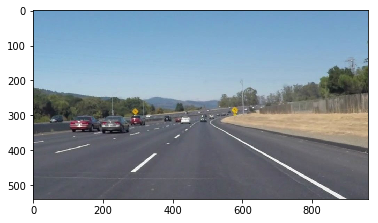

In [3]:
for test_image in images:
    
    file_name = test_image.split('/')[1]
    
    image = mpimg.imread(test_image)

    gray_image = grayscale(image)
    plt.imshow(image)

    blurred_image = gaussian_blur(gray_image, 5)

    edges = canny(blurred_image, 50, 150)

    imshape = image.shape
    vertices = np.array([[(0,imshape[0]),(450, 320), (520, 320), (imshape[1],imshape[0])]], dtype=np.int32)
    my_region = region_of_interest(edges, vertices)

    rho = 2
    theta = np.pi/180
    threshold = 15
    min_line_length = 40
    max_line_gap = 40
    line_image = hough_lines(my_region, rho, theta, threshold, min_line_length, max_line_gap)

    final_image = weighted_img(line_image, image, α=0.8, β=1., γ=0.)

    cv2.imwrite("test_images_output/" + file_name,final_image)
    
    
    

## Applying the pipeline on the videos

Starting with keeping the pipeline separate to apply on the image frames in the video

In [4]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

"Using my pipeline here"
def process_image(image):
    gray_image = grayscale(image)
    plt.imshow(image)

    blurred_image = gaussian_blur(gray_image, 5)

    edges = canny(blurred_image, 50, 150)

    imshape = image.shape
    vertices = np.array([[(0,imshape[0]),(450, 320), (520, 320), (imshape[1],imshape[0])]], dtype=np.int32)
    my_region = region_of_interest(edges, vertices)

    rho = 2
    theta = np.pi/180
    threshold = 15
    min_line_length = 40
    max_line_gap = 40
    line_image = hough_lines(my_region, rho, theta, threshold, min_line_length, max_line_gap)

    final_image = weighted_img(line_image, image, α=0.8, β=1., γ=0.)
    result = final_image

    return result




[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:19<00:00, 10.18it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 7.64 s, sys: 590 ms, total: 8.23 s
Wall time: 21 s
[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [01:01<00:00, 10.75it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 23.4 s, sys: 1.63 s, total: 25 s
Wall time: 1min 3s


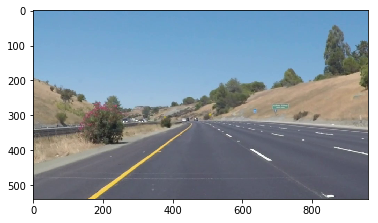

In [5]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image)                  #This statement will use my pipeline for the series of images in the video
%time white_clip.write_videofile(white_output, audio=False)

yellow_output = 'test_videos_output/solidYellowLeft.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)




## To play video inline

In [6]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))


HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))